https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/

# data read

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [2]:
import warnings
warnings.filterwarnings( 'ignore' )

In [3]:
df=pd.read_csv(r'C:/Users/user/Dropbox/Dataset/household_power_consumption.txt', sep=';', header=0, low_memory=False, infer_datetime_format=True, parse_dates={'datetime':[0,1]}, index_col=['datetime'])
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.840,18.400,0.000,1.000,17.0
2006-12-16 17:25:00,5.360,0.436,233.630,23.000,0.000,1.000,16.0
2006-12-16 17:26:00,5.374,0.498,233.290,23.000,0.000,2.000,17.0
2006-12-16 17:27:00,5.388,0.502,233.740,23.000,0.000,1.000,17.0
2006-12-16 17:28:00,3.666,0.528,235.680,15.800,0.000,1.000,17.0


# data preprocessing

In [4]:
df = df.replace('?', np.nan)
df.isnull().sum()

Global_active_power      25979
Global_reactive_power    25979
Voltage                  25979
Global_intensity         25979
Sub_metering_1           25979
Sub_metering_2           25979
Sub_metering_3           25979
dtype: int64

In [5]:
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]
df = df.astype('float32')
fill_missing(df.values)
df.isnull().sum()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

In [6]:
daily_df = df.resample('D').sum()
daily_df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
datetime,,,,,,,
2006-12-16,1209.176025,34.922001,93552.53125,5180.799805,0.0,546.0,4926.0
2006-12-17,3390.459961,226.005997,345725.31250,14398.599609,2033.0,4187.0,13341.0
2006-12-18,2203.825928,161.792007,347373.62500,9247.200195,1063.0,2621.0,14018.0
2006-12-19,1666.193970,150.942001,348479.00000,7094.000000,839.0,7602.0,6197.0
2006-12-20,2225.748047,160.998001,348923.62500,9313.000000,0.0,2648.0,14063.0


In [7]:
train_df,test_df = daily_df[1:1081], daily_df[1081:] 

## scale setting
    - train 데이터를 통한 스케일러 세팅

In [8]:
train = train_df
scalers={}
for i in train_df.columns:
    scaler = MinMaxScaler(feature_range=(-1,1))
    s_s = scaler.fit_transform(train[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+ i] = scaler
    train[i]=s_s
test = test_df
for i in train_df.columns:
    scaler = scalers['scaler_'+i]
    s_s = scaler.transform(test[i].values.reshape(-1,1))
    s_s=np.reshape(s_s,len(s_s))
    scalers['scaler_'+i] = scaler
    test[i]=s_s

## data split (train, test)

In [9]:
#
# n_past ==> no of past observations
# n_future ==> no of future observations 
#
def split_series(series, n_past, n_future):
    X, y = list(), list()
    for window_start in range(len(series)):
        past_end = window_start + n_past
        future_end = past_end + n_future
        if future_end > len(series):
            break
        # slicing the past and future parts of the window
        past, future = series[window_start:past_end, :], series[past_end:future_end, :]
        X.append(past)
        y.append(future)
    return np.array(X), np.array(y)

In [10]:
n_past = 10
n_future = 5 
n_features = 7

In [11]:
X_train, y_train = split_series(train.values,n_past, n_future)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1],n_features))
y_train = y_train.reshape((y_train.shape[0], y_train.shape[1], n_features))
X_test, y_test = split_series(test.values,n_past, n_future)
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1],n_features))
y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], n_features))

In [12]:
X_train.shape
# 데이터 갯수, window 사이즈, 컬럼갯수

(1066, 10, 7)

# model

## lstm 
- lstm은 long short term memory의 줄임말로 주로 시계열처리를 하는데 사용한다. 
- lstm은 input값을 받으면 hidden state와 cell state를 가지게 된다. 
- cell state는 lstm이 굴러가게 하는 일종의 체인역활을 하며 기억을 오랫동안 유지할수 있는 구조로 되어있다. 
- hidden state는 RNN 처럼 계층의 출력이 되면 다음 타임 스템으로 정보를 넘기게 된다.

### tensorflow에서의 lstm 사용방식
- lstm의 cell state의 hidden state에 대한 출력을 바꾸는 변수는 return_state 와 return_sequences이다. 
- 두개의 변수는 boolean 형태로 주어지게 되며 둘다 fasle일경우 마지막 결과값만 (마지막 hidden state)값만 출력하게 된다.
- return_sequence = True로 설정할 경우 각 time step별 hidden state를 모두 출력하게 된다. 
    - 길이가 5인경우에는 5의 hidden state값이 모두 출력된다. 
    - 이는 보통 attention을 사용하기 위함이다.
- return_state = True 로 설정한 경우 마지막 time step에서의 output(hidden_state), hidden state와 cell_state가 출력된다. 
    - 마지막 output 값이 2번 출력되고, cell state가 추가로 출력된다. 
- return_sequence와 return_state를 모두 True로 하게 되면 각 time step별 hidden state의 마지막 hidden state, 마지막 cell state값이 출력된다
- lstm을 각 타임 스텝별로 분리해서 넣어주는 경우가 있다. 그런 경우에는 initial_state를 사용해야 한다. 
    - 전체 sequence의 길이가 T이고 feature가 n이면 LSTM에 하나의 타임 스텝별로 넣기 때문에 input shape가 batch,1,n 이 된다. 
    - 이런식으로 T번 반복하여 넣어주면 되는데 기존의 hidden state와 cell state를 전달해줘야 함으로 initial_state를 사용한다.

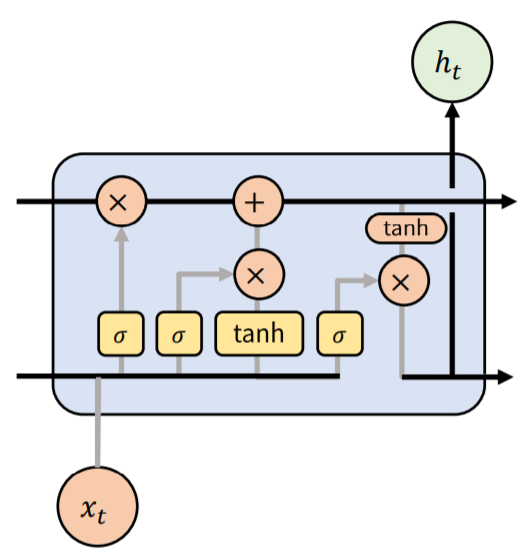

In [13]:
# E1D1
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs1[0])

#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_outputs1 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l1)

#
model_e1d1 = tf.keras.models.Model(encoder_inputs,decoder_outputs1)

#
model_e1d1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 100), (None, 43200       input_1[0][0]                    
__________________________________________________________________________________________________
repeat_vector (RepeatVector)    (None, 5, 100)       0           lstm[0][0]                       
__________________________________________________________________________________________________
lstm_1 (LSTM)                   (None, 5, 100)       80400       repeat_vector[0][0]              
                                                                 lstm[0][1]            

In [14]:
# E2D2
# n_features ==> no of features at each timestep in the data.
#
encoder_inputs = tf.keras.layers.Input(shape=(n_past, n_features))
encoder_l1 = tf.keras.layers.LSTM(100,return_sequences = True, return_state=True)
encoder_outputs1 = encoder_l1(encoder_inputs)
encoder_states1 = encoder_outputs1[1:]
encoder_l2 = tf.keras.layers.LSTM(100, return_state=True)
encoder_outputs2 = encoder_l2(encoder_outputs1[0])
encoder_states2 = encoder_outputs2[1:]
#
decoder_inputs = tf.keras.layers.RepeatVector(n_future)(encoder_outputs2[0])
#
decoder_l1 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_inputs,initial_state = encoder_states1)
decoder_l2 = tf.keras.layers.LSTM(100, return_sequences=True)(decoder_l1,initial_state = encoder_states2)
decoder_outputs2 = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(n_features))(decoder_l2)
#
model_e2d2 = tf.keras.models.Model(encoder_inputs,decoder_outputs2)
#
model_e2d2.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 10, 7)]      0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   [(None, 10, 100), (N 43200       input_2[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   [(None, 100), (None, 80400       lstm_2[0][0]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 5, 100)       0           lstm_3[0][0]                     
_______________________________________________________________________________________

In [15]:
reduce_lr = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.90 ** x)
model_e1d1.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e1d1=model_e1d1.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])
model_e2d2.compile(optimizer=tf.keras.optimizers.Adam(), loss=tf.keras.losses.Huber())
history_e2d2=model_e2d2.fit(X_train,y_train,epochs=25,validation_data=(X_test,y_test),batch_size=32,verbose=0,callbacks=[reduce_lr])

In [16]:
pred1_e1d1=model_e1d1.predict(X_test)
pred1_e2d2=model_e2d2.predict(X_test)

In [17]:
for index,i in enumerate(train_df.columns):
    scaler = scalers['scaler_'+i]
    pred1_e1d1[:,:,index]=scaler.inverse_transform(pred1_e1d1[:,:,index])
#     pred_e1d1[:,:,index]=scaler.inverse_transform(pred_e1d1[:,:,index])
    pred1_e2d2[:,:,index]=scaler.inverse_transform(pred1_e2d2[:,:,index])
#     pred_e2d2[:,:,index]=scaler.inverse_transform(pred_e2d2[:,:,index])
    y_train[:,:,index]=scaler.inverse_transform(y_train[:,:,index])
    y_test[:,:,index]=scaler.inverse_transform(y_test[:,:,index])

In [18]:
from sklearn.metrics import mean_absolute_error
for index,i in enumerate(train_df.columns):
    print(i)
    for j in range(1,6):
        print("Day ",j,":")
        print("MAE-E1D1 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e1d1[:,j-1,index]),end=", ")
        print("MAE-E2D2 : ",mean_absolute_error(y_test[:,j-1,index],pred1_e2d2[:,j-1,index]))
    print()
    print()

Global_active_power
Day  1 :
MAE-E1D1 :  244.0435, MAE-E2D2 :  246.71251
Day  2 :
MAE-E1D1 :  255.70868, MAE-E2D2 :  255.42703
Day  3 :
MAE-E1D1 :  266.24628, MAE-E2D2 :  263.99182
Day  4 :
MAE-E1D1 :  269.27664, MAE-E2D2 :  265.84952
Day  5 :
MAE-E1D1 :  272.7989, MAE-E2D2 :  270.77502


Global_reactive_power
Day  1 :
MAE-E1D1 :  29.613573, MAE-E2D2 :  30.380285
Day  2 :
MAE-E1D1 :  31.23559, MAE-E2D2 :  31.681866
Day  3 :
MAE-E1D1 :  31.825546, MAE-E2D2 :  32.14671
Day  4 :
MAE-E1D1 :  32.116173, MAE-E2D2 :  32.5102
Day  5 :
MAE-E1D1 :  32.3727, MAE-E2D2 :  32.641434


Voltage
Day  1 :
MAE-E1D1 :  1202.3668, MAE-E2D2 :  1301.2173
Day  2 :
MAE-E1D1 :  1322.0544, MAE-E2D2 :  1371.1917
Day  3 :
MAE-E1D1 :  1429.9685, MAE-E2D2 :  1459.1703
Day  4 :
MAE-E1D1 :  1518.9528, MAE-E2D2 :  1533.7262
Day  5 :
MAE-E1D1 :  1711.5985, MAE-E2D2 :  1716.625


Global_intensity
Day  1 :
MAE-E1D1 :  1033.5785, MAE-E2D2 :  1055.0283
Day  2 :
MAE-E1D1 :  1066.2806, MAE-E2D2 :  1081.0955
Day  3 :
MAE-E1D1 

In [21]:
y_test.shape

(347, 5, 7)

In [23]:
pred1_e1d1.shape

(347, 5, 7)